# Video stream train

In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime

import tensorflow as tf

# Keras module and tools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, RandomFlip
from keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras_cv.layers import RandomCutout
import keras_tuner

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6} # to match the audio stream labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

path_frames_face_BW = "Datasets/RAVDESS_frames_face_BW/"
path_frames = "Datasets/RAVDESS_frames/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

val_actors = ['19', '20']
test_actors = ['21', '22', '23', '24']

## Model 4: 112x112 BW Faces

### Dataset creation

In [4]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames_face_BW):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [5]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [6]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 23184 
batch size: 64 
batch number: 362


In [7]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 64 
batch number: 42


#### Augmentation

In [60]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
])

#### Examples

(112, 112, 1)


(-0.5, 111.5, 111.5, -0.5)

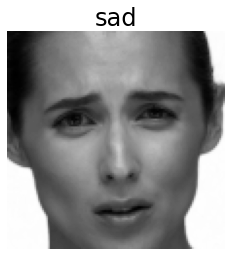

In [61]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
# plt.savefig('Plots/model4_input.png')

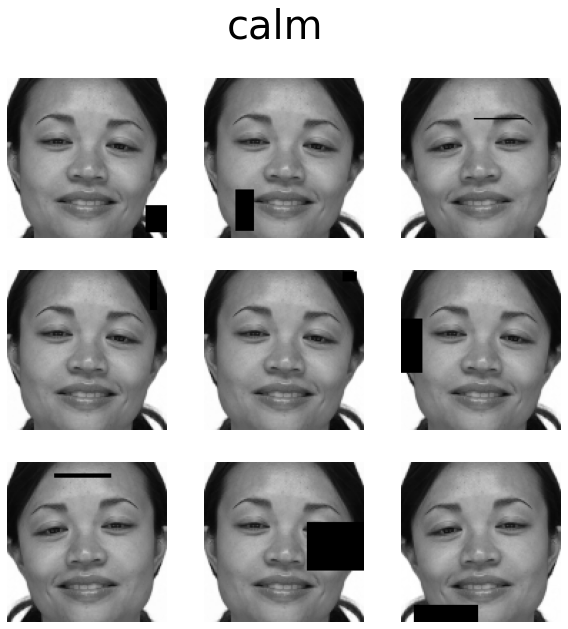

In [79]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
plt.savefig('Plots/model4_augmentation.png')

### Net Architecture

In [63]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [64]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [69]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.5, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.5, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

# x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_4')(x)
# x = BatchNormalization(name='batchnorm_x')(x)
# x = Activation('elu')(x)
# x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_4')(x)

# x = Dropout(0.5, name='dropout_4')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net_4 = Model(inputs=input, outputs=output)
net_4.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 112, 112, 1)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation_120 (Activation)  (None, 112, 112, 32)     0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                          

In [70]:
net_4.compile(
        optimizer = Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

### Training

In [71]:
history_4 = net_4.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10
223/362 [=================>............] - ETA: 14s - loss: 2.3782 - sparse_categorical_accuracy: 0.2049

KeyboardInterrupt: 

### Evaluation

In [ ]:
net_4.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

42/42 [==============================] - 1s 26ms/step - loss: 2.0831 - sparse_categorical_accuracy: 0.4684


[2.0830554962158203, 0.4683779776096344]

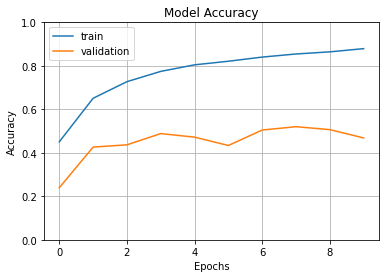

In [ ]:
fig1 = plt.gcf()
plt.plot(history_4.history['sparse_categorical_accuracy'])
plt.plot(history_4.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model4_accuracy.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_4(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       384
           1       0.41      0.86      0.56       384
           2       0.70      0.65      0.67       384
           3       0.34      0.20      0.25       384
           4       0.86      0.32      0.46       384
           5       0.87      0.28      0.43       384
           6       0.29      0.51      0.37       384

    accuracy                           0.47      2688
   macro avg       0.57      0.47      0.46      2688
weighted avg       0.57      0.47      0.46      2688



## Model 5: 112x112 BW Faces (normalized with mean_face)

### Dataset creation

In [121]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(path_frames_face_BW):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [122]:
mean_face = np.load('Other/mean_face.npy')
mean_face = tf.convert_to_tensor(mean_face, dtype=tf.float32)

In [123]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    image = image - mean_face                                                       # subctract mean face
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])                         # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [124]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 23184 
batch size: 64 
batch number: 362


In [125]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 64 
batch number: 42


#### Augmentation

In [126]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    # RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
])

#### Examples

(112, 112, 1)


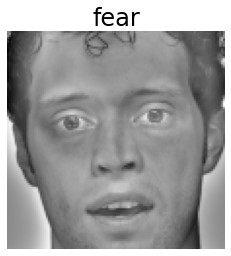

In [127]:
examples = train_ds.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')
plt.savefig('Plots/model5_input.png')

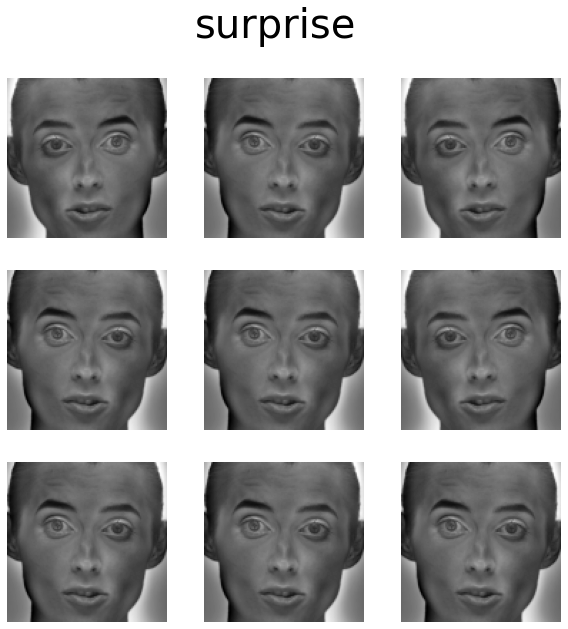

In [128]:
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")
# plt.savefig('Plots/model5_augmentation.png')

### Net Architecture

In [129]:
# frame_type = ''
epochs = 10
lr = 0.001
momentum = 0.5

In [130]:
checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}]_face.hdf5'

reduce_lr = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [131]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.4, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.4, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

net_5 = Model(inputs=input, outputs=output)
net_5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 112, 112, 1)       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation_10 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                           

In [132]:
net_5.compile(
        optimizer = Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

### Hyper-Parameters optimization

In [133]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_sparse_categorical_accuracy",
#     # max_trials=3,
#     executions_per_trial=1,
#     overwrite=True,
# )

# tuner.search_space_summary()

In [134]:
# tuner.search(train_ds,
#              epochs=3,
#              validation_data=val_ds,
#              batch_size=batch_size,
#              steps_per_epoch=step_per_epoch_train,
#              validation_steps=step_per_epoch_val)

In [135]:
# tuner.get_best_hyperparameters()[0].values

In [136]:
# best_model = tuner.get_best_models(num_models=1)[0]
# # Build the model.
# # Needed for `Sequential` without specified `input_shape`.
# best_model.build()
# # best_model.summary()

### Training

In [137]:
history_5 = net_5.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[save_best],
                    verbose=1)

Epoch 1/10
362/362 [==============================] - 51s 137ms/step - loss: 1.4319 - sparse_categorical_accuracy: 0.5107 - val_loss: 2.4050 - val_sparse_categorical_accuracy: 0.2749
Epoch 2/10
362/362 [==============================] - 51s 141ms/step - loss: 0.8329 - sparse_categorical_accuracy: 0.6994 - val_loss: 1.9437 - val_sparse_categorical_accuracy: 0.4092
Epoch 3/10
362/362 [==============================] - 52s 144ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.7651 - val_loss: 2.2104 - val_sparse_categorical_accuracy: 0.4185
Epoch 4/10
362/362 [==============================] - 50s 138ms/step - loss: 0.5501 - sparse_categorical_accuracy: 0.8041 - val_loss: 2.0713 - val_sparse_categorical_accuracy: 0.4461
Epoch 5/10
362/362 [==============================] - 50s 139ms/step - loss: 0.4824 - sparse_categorical_accuracy: 0.8320 - val_loss: 2.1402 - val_sparse_categorical_accuracy: 0.4520
Epoch 6/10
362/362 [==============================] - 50s 138ms/step - loss: 0.4341 -

### Evaluation

In [138]:
net_5.evaluate(val_ds,
            batch_size=batch_size,
            steps=step_per_epoch_val)

42/42 [==============================] - 2s 39ms/step - loss: 2.3557 - sparse_categorical_accuracy: 0.4955


[2.3556814193725586, 0.4955357015132904]

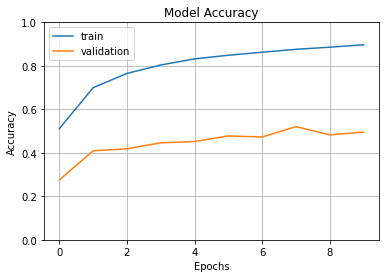

In [143]:
fig1 = plt.gcf()
plt.plot(history_5.history['sparse_categorical_accuracy'])
plt.plot(history_5.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model5_accuracy.png')
plt.show()

In [140]:
from sklearn.metrics import classification_report
y_val = []
y_pred = []
i = 1
for image, target in val_ds:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(net_5(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53       384
           1       0.45      0.95      0.61       384
           2       0.60      0.66      0.63       384
           3       0.25      0.26      0.25       384
           4       0.74      0.58      0.65       384
           5       0.79      0.21      0.33       384
           6       0.38      0.33      0.35       384

    accuracy                           0.50      2688
   macro avg       0.54      0.50      0.48      2688
weighted avg       0.54      0.50      0.48      2688

